In [ ]:
from tropycal import realtime

# DataSource: UCAR
This datasource

In [2]:
realtime_obj = realtime.Realtime(jtwc=True, jtwc_source='ucar')

--> Starting to read in current storm data
--> Completed reading in current storm data (96.91 seconds)


In [3]:
active_storms = realtime_obj.list_active_storms()
active_storms

['AL132023', 'AL142023', 'EP112023', 'WP122023']

<GeoAxes: title={'left': 'Summary & NHC 7-Day Formation Outlook', 'right': 'Valid: 03 UTC 08 Sep 2023'}>

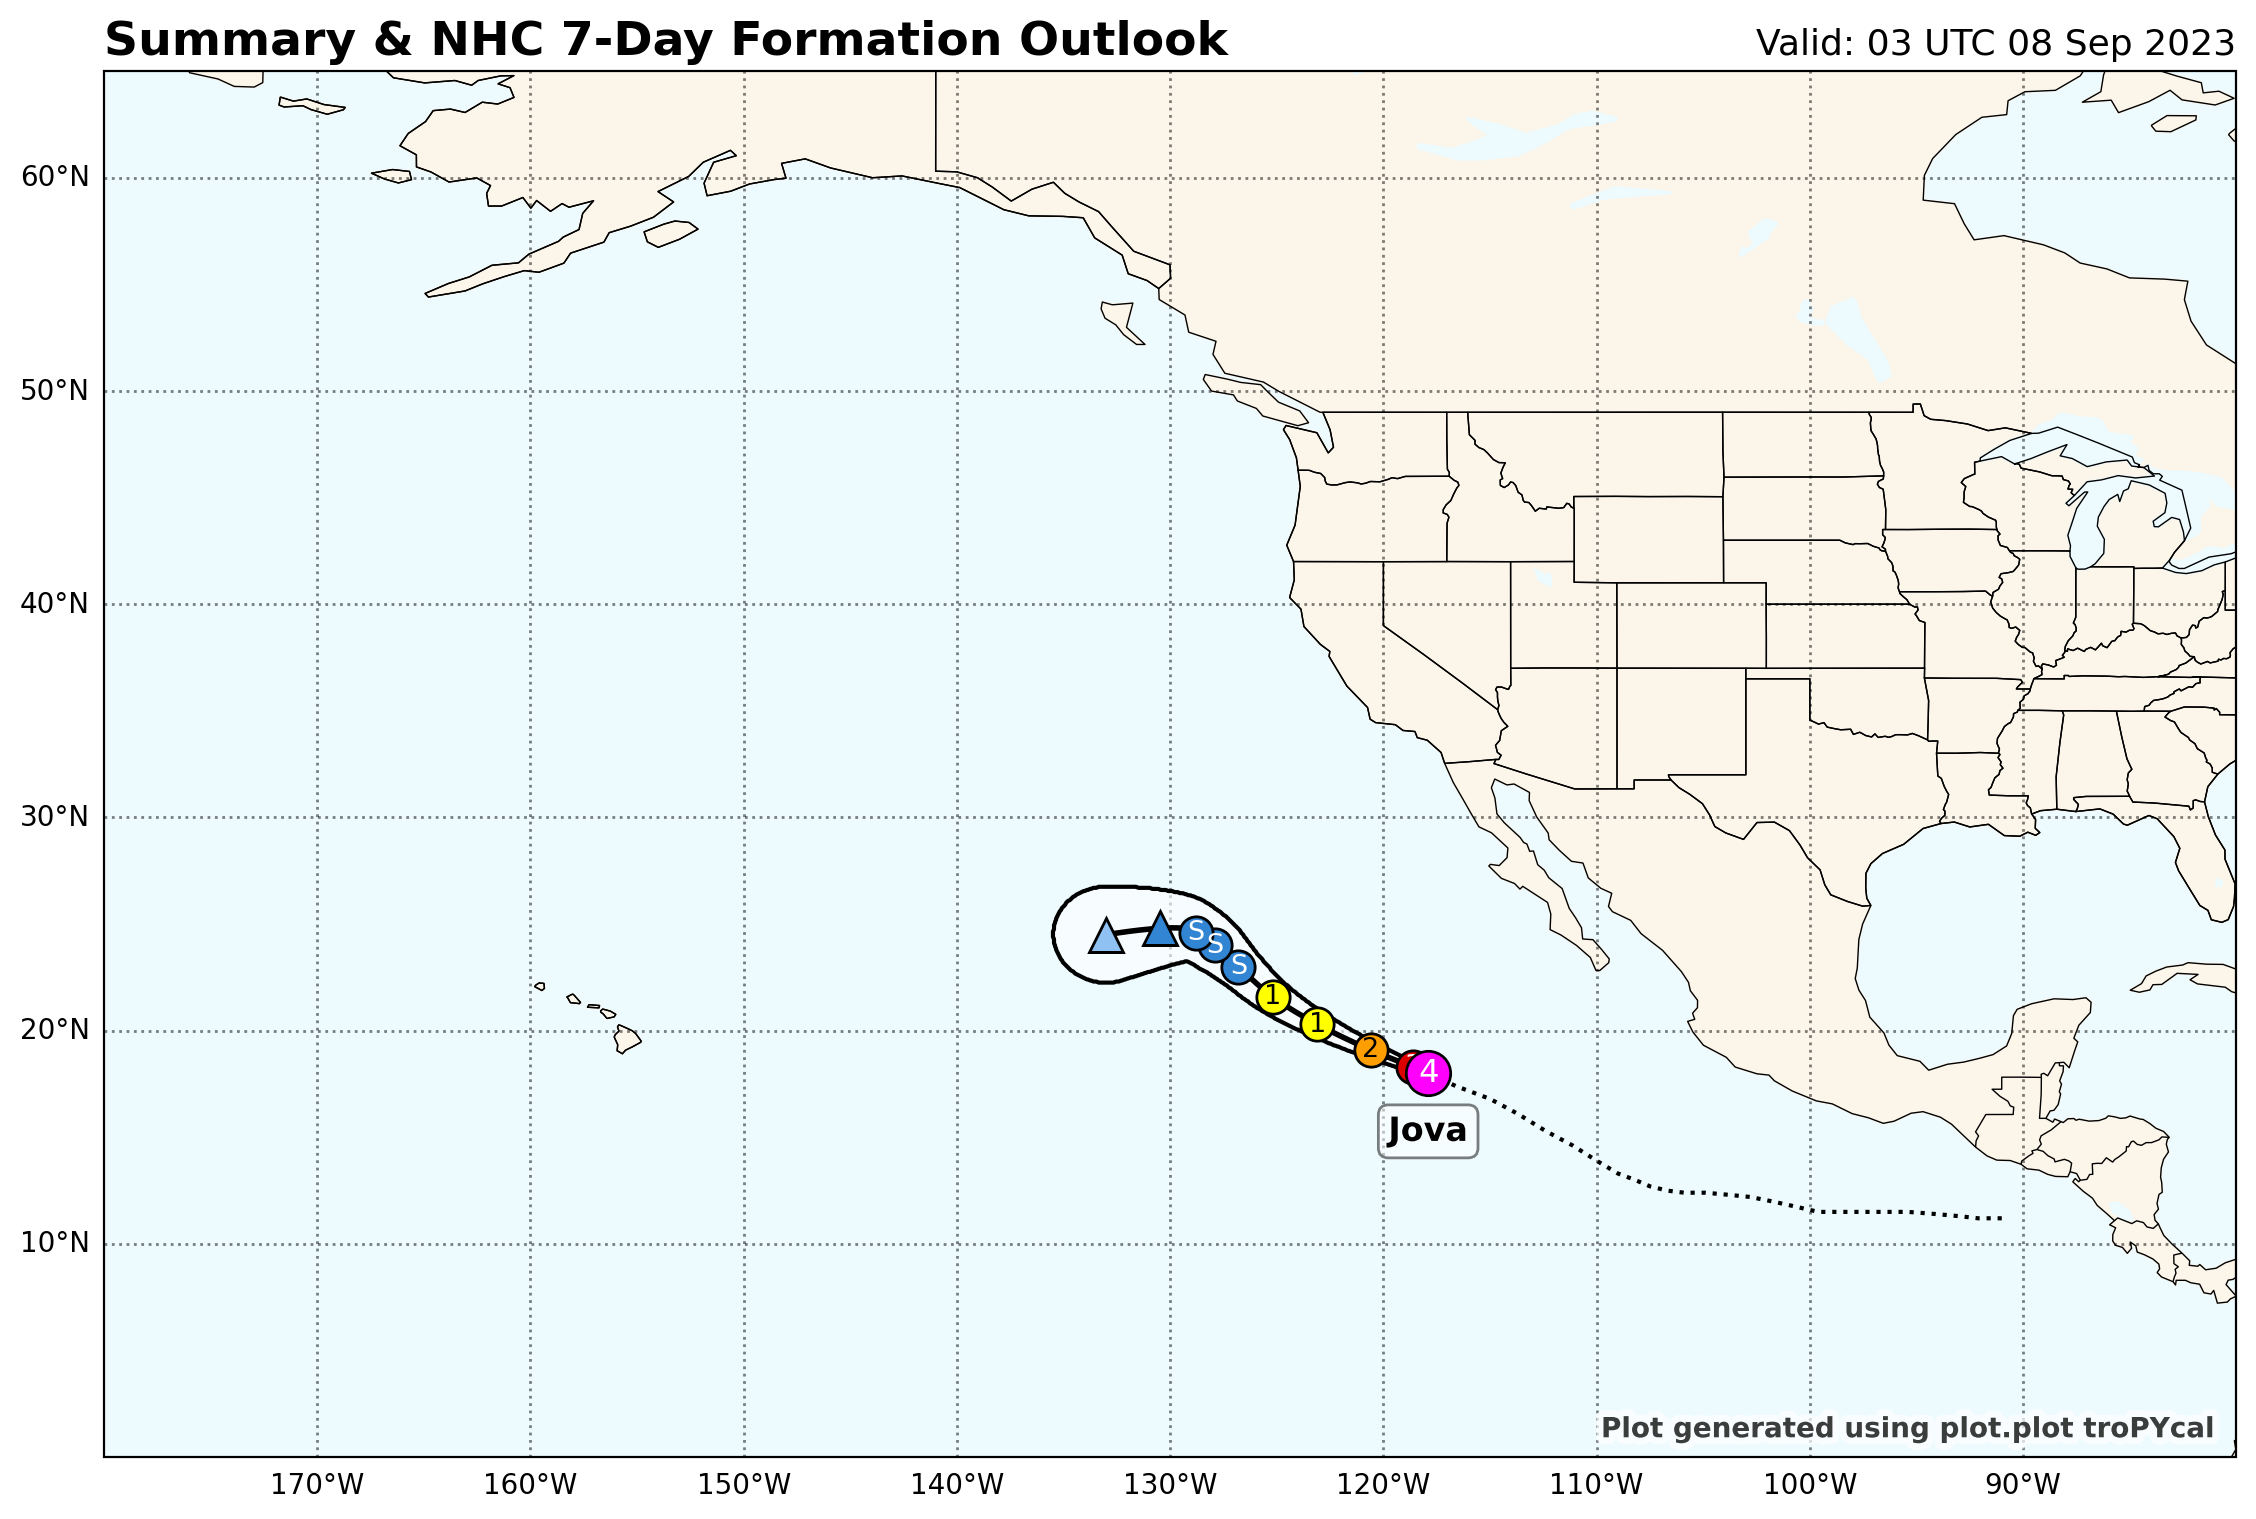

In [4]:
realtime_obj.plot_summary(domain='east_pacific')

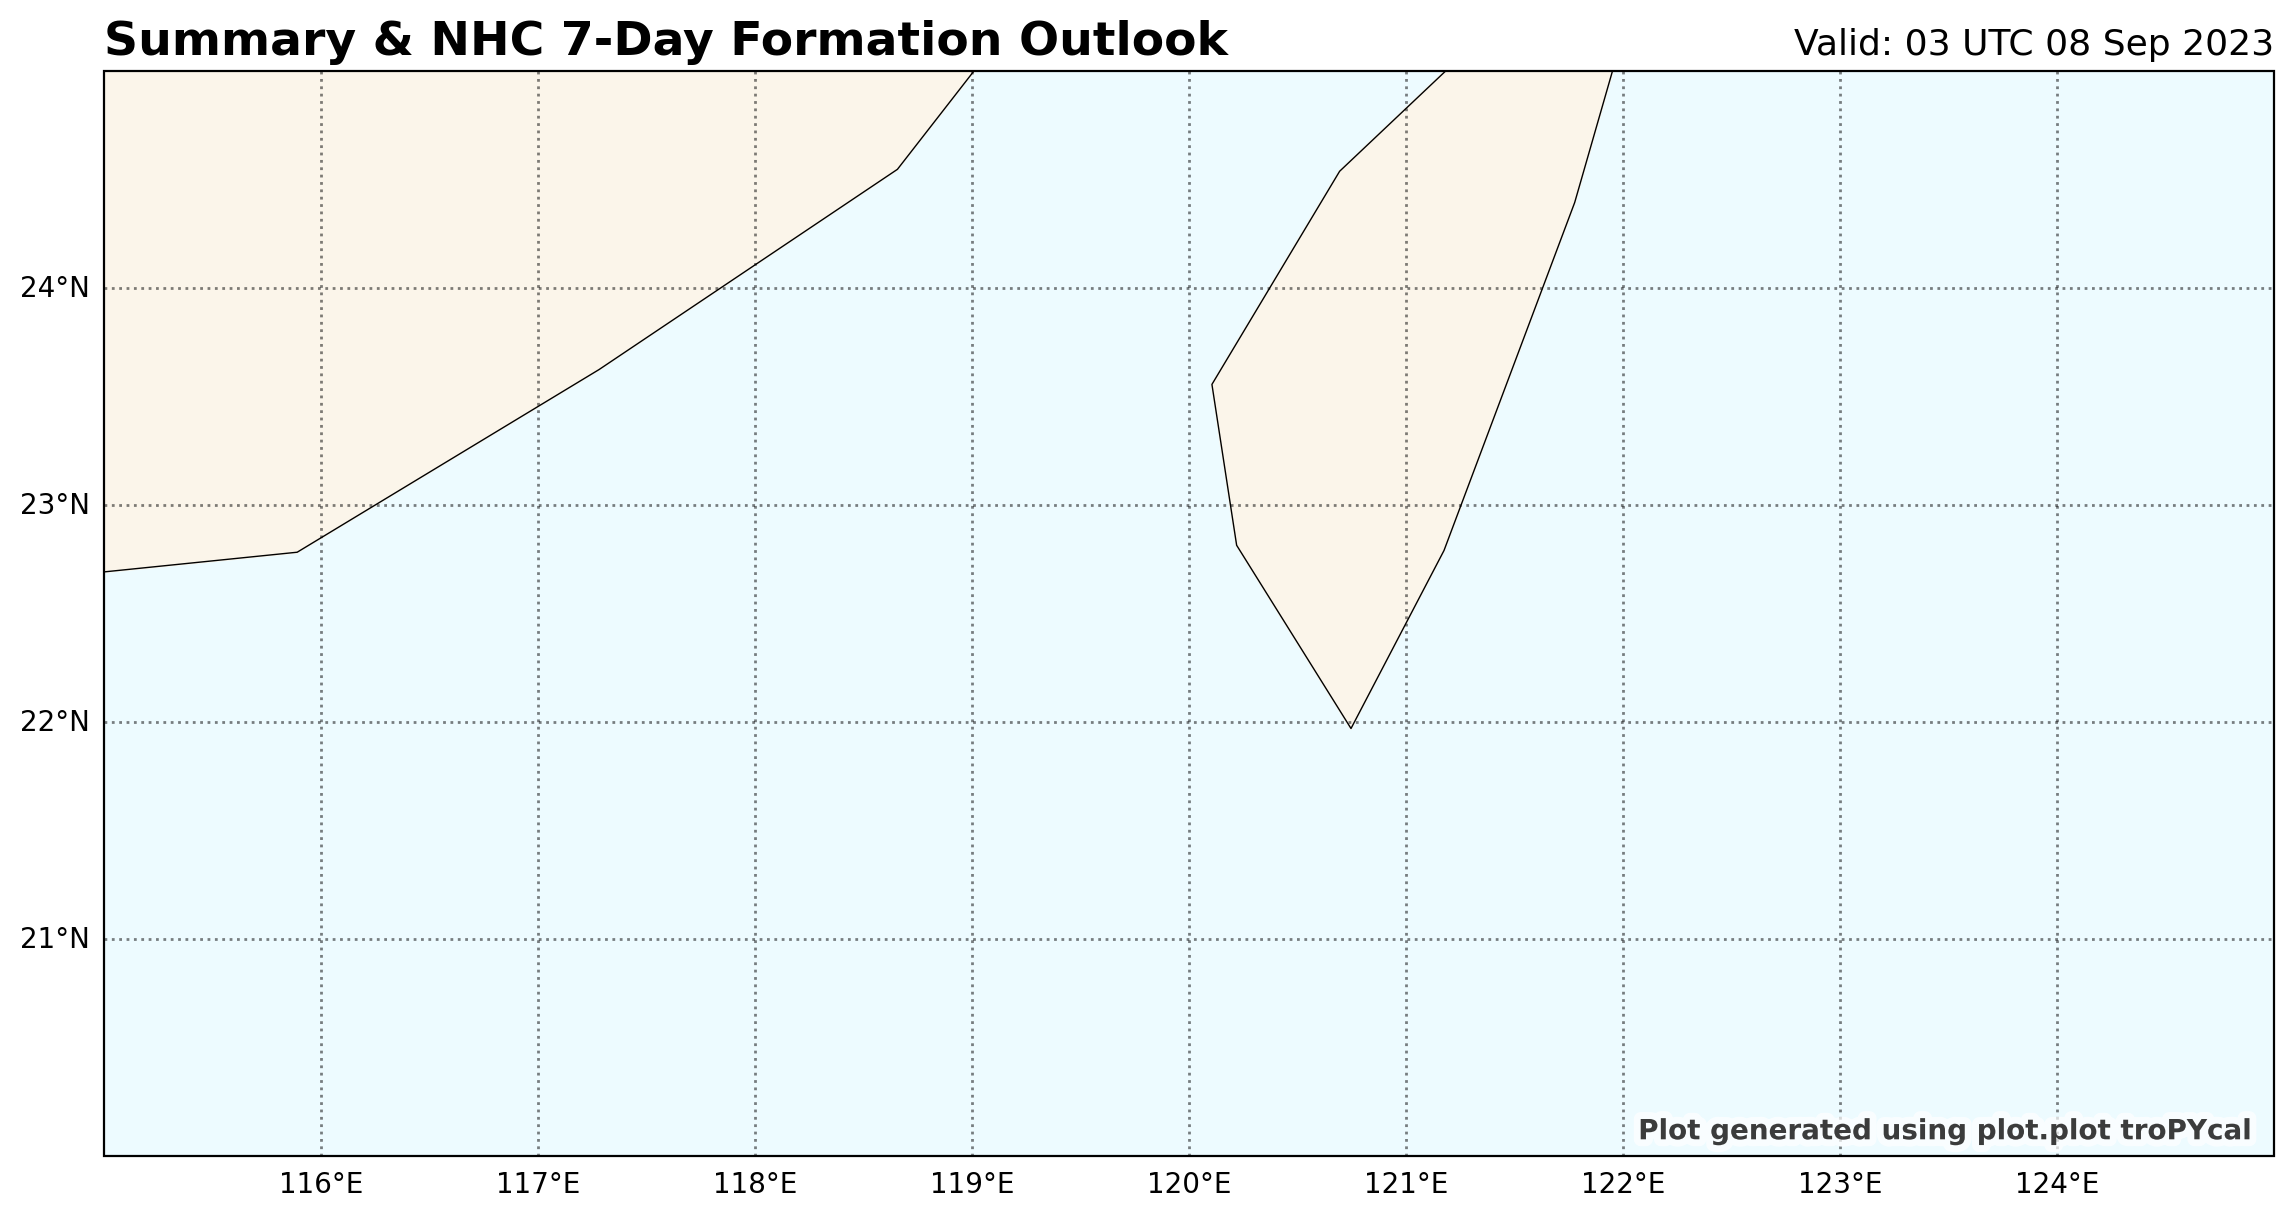

In [5]:
tw_domain = {'w':115,'e':125,'s':20,'n':25}
p = realtime_obj.plot_summary(domain=tw_domain)

In [37]:
storm = realtime_obj.get_storm(active_storms[2])

In [38]:
storm

<tropycal.realtime.RealtimeStorm>
Storm Summary:
    Maximum Wind:      140 knots
    Minimum Pressure:  929 hPa
    Start Time:        1800 UTC 04 September 2023
    End Time:          0000 UTC 08 September 2023

Variables:
    time        (datetime) [2023-09-02 00:00:00 .... 2023-09-08 00:00:00]
    extra_obs   (int64) [0 .... 0]
    special     (str) [ .... ]
    type        (str) [DB .... HU]
    lat         (float64) [11.2 .... 18.0]
    lon         (float64) [-91.0 .... -117.9]
    vmax        (int64) [15 .... 115]
    mslp        (int64) [1010 .... 947]
    wmo_basin   (str) [east_pacific .... east_pacific]

More Information:
    id:              EP112023
    operational_id:  EP112023
    name:            JOVA
    year:            2023
    season:          2023
    basin:           east_pacific
    source_info:     NHC Hurricane Database
    invest:          False
    source_method:   NHC's Automated Tropical Cyclone Forecasting System (ATCF)
    source_url:      https://ftp.nhc

In [39]:
storm_forecast = storm.get_forecast_realtime(ssl_certificate=False)

In [40]:
lats = storm['lat'].tolist() + storm_forecast['lat']
lons = storm['lon'].tolist() + storm_forecast['lon']

storm_s = min(lats) - 5
storm_n = max(lats) + 5
storm_w = max(lons) + 5
storm_e = min(lons) - 5
storm_box = (storm_w, storm_e, storm_s, storm_n)
storm_box

(-86.0, -138.0, 6.199999999999999, 29.8)

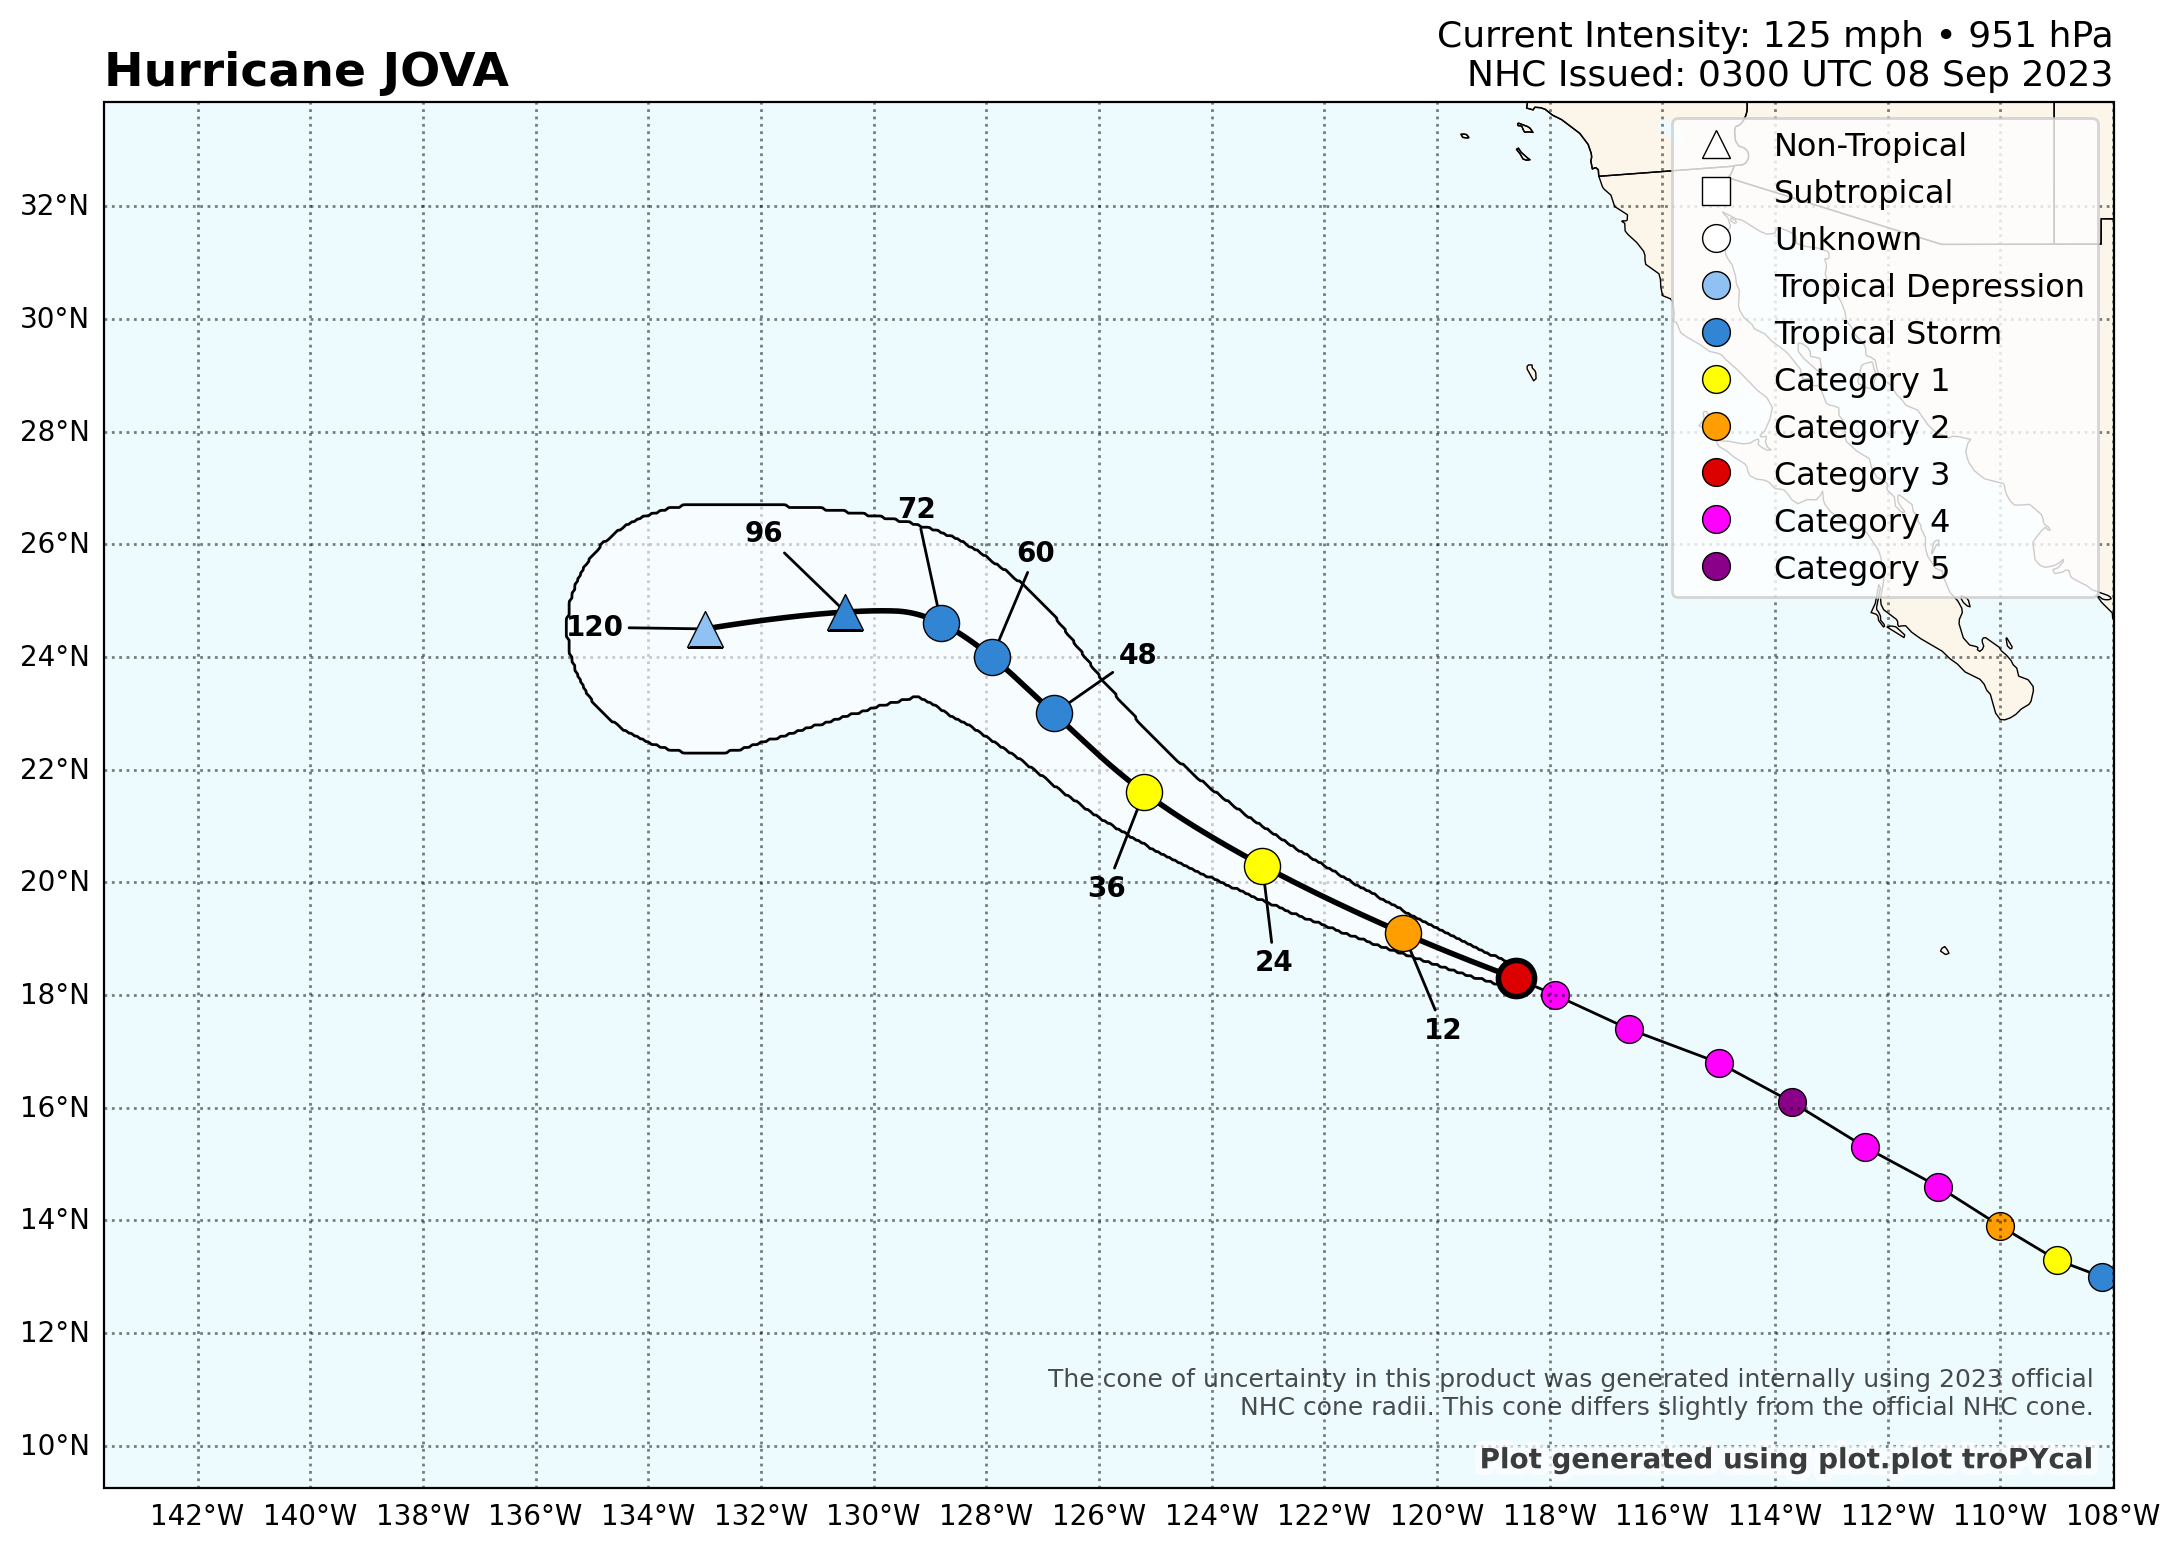

In [41]:
a = storm.plot_forecast_realtime(ssl_certificate=False, prop={'ms':10, 'cone_lw':2})

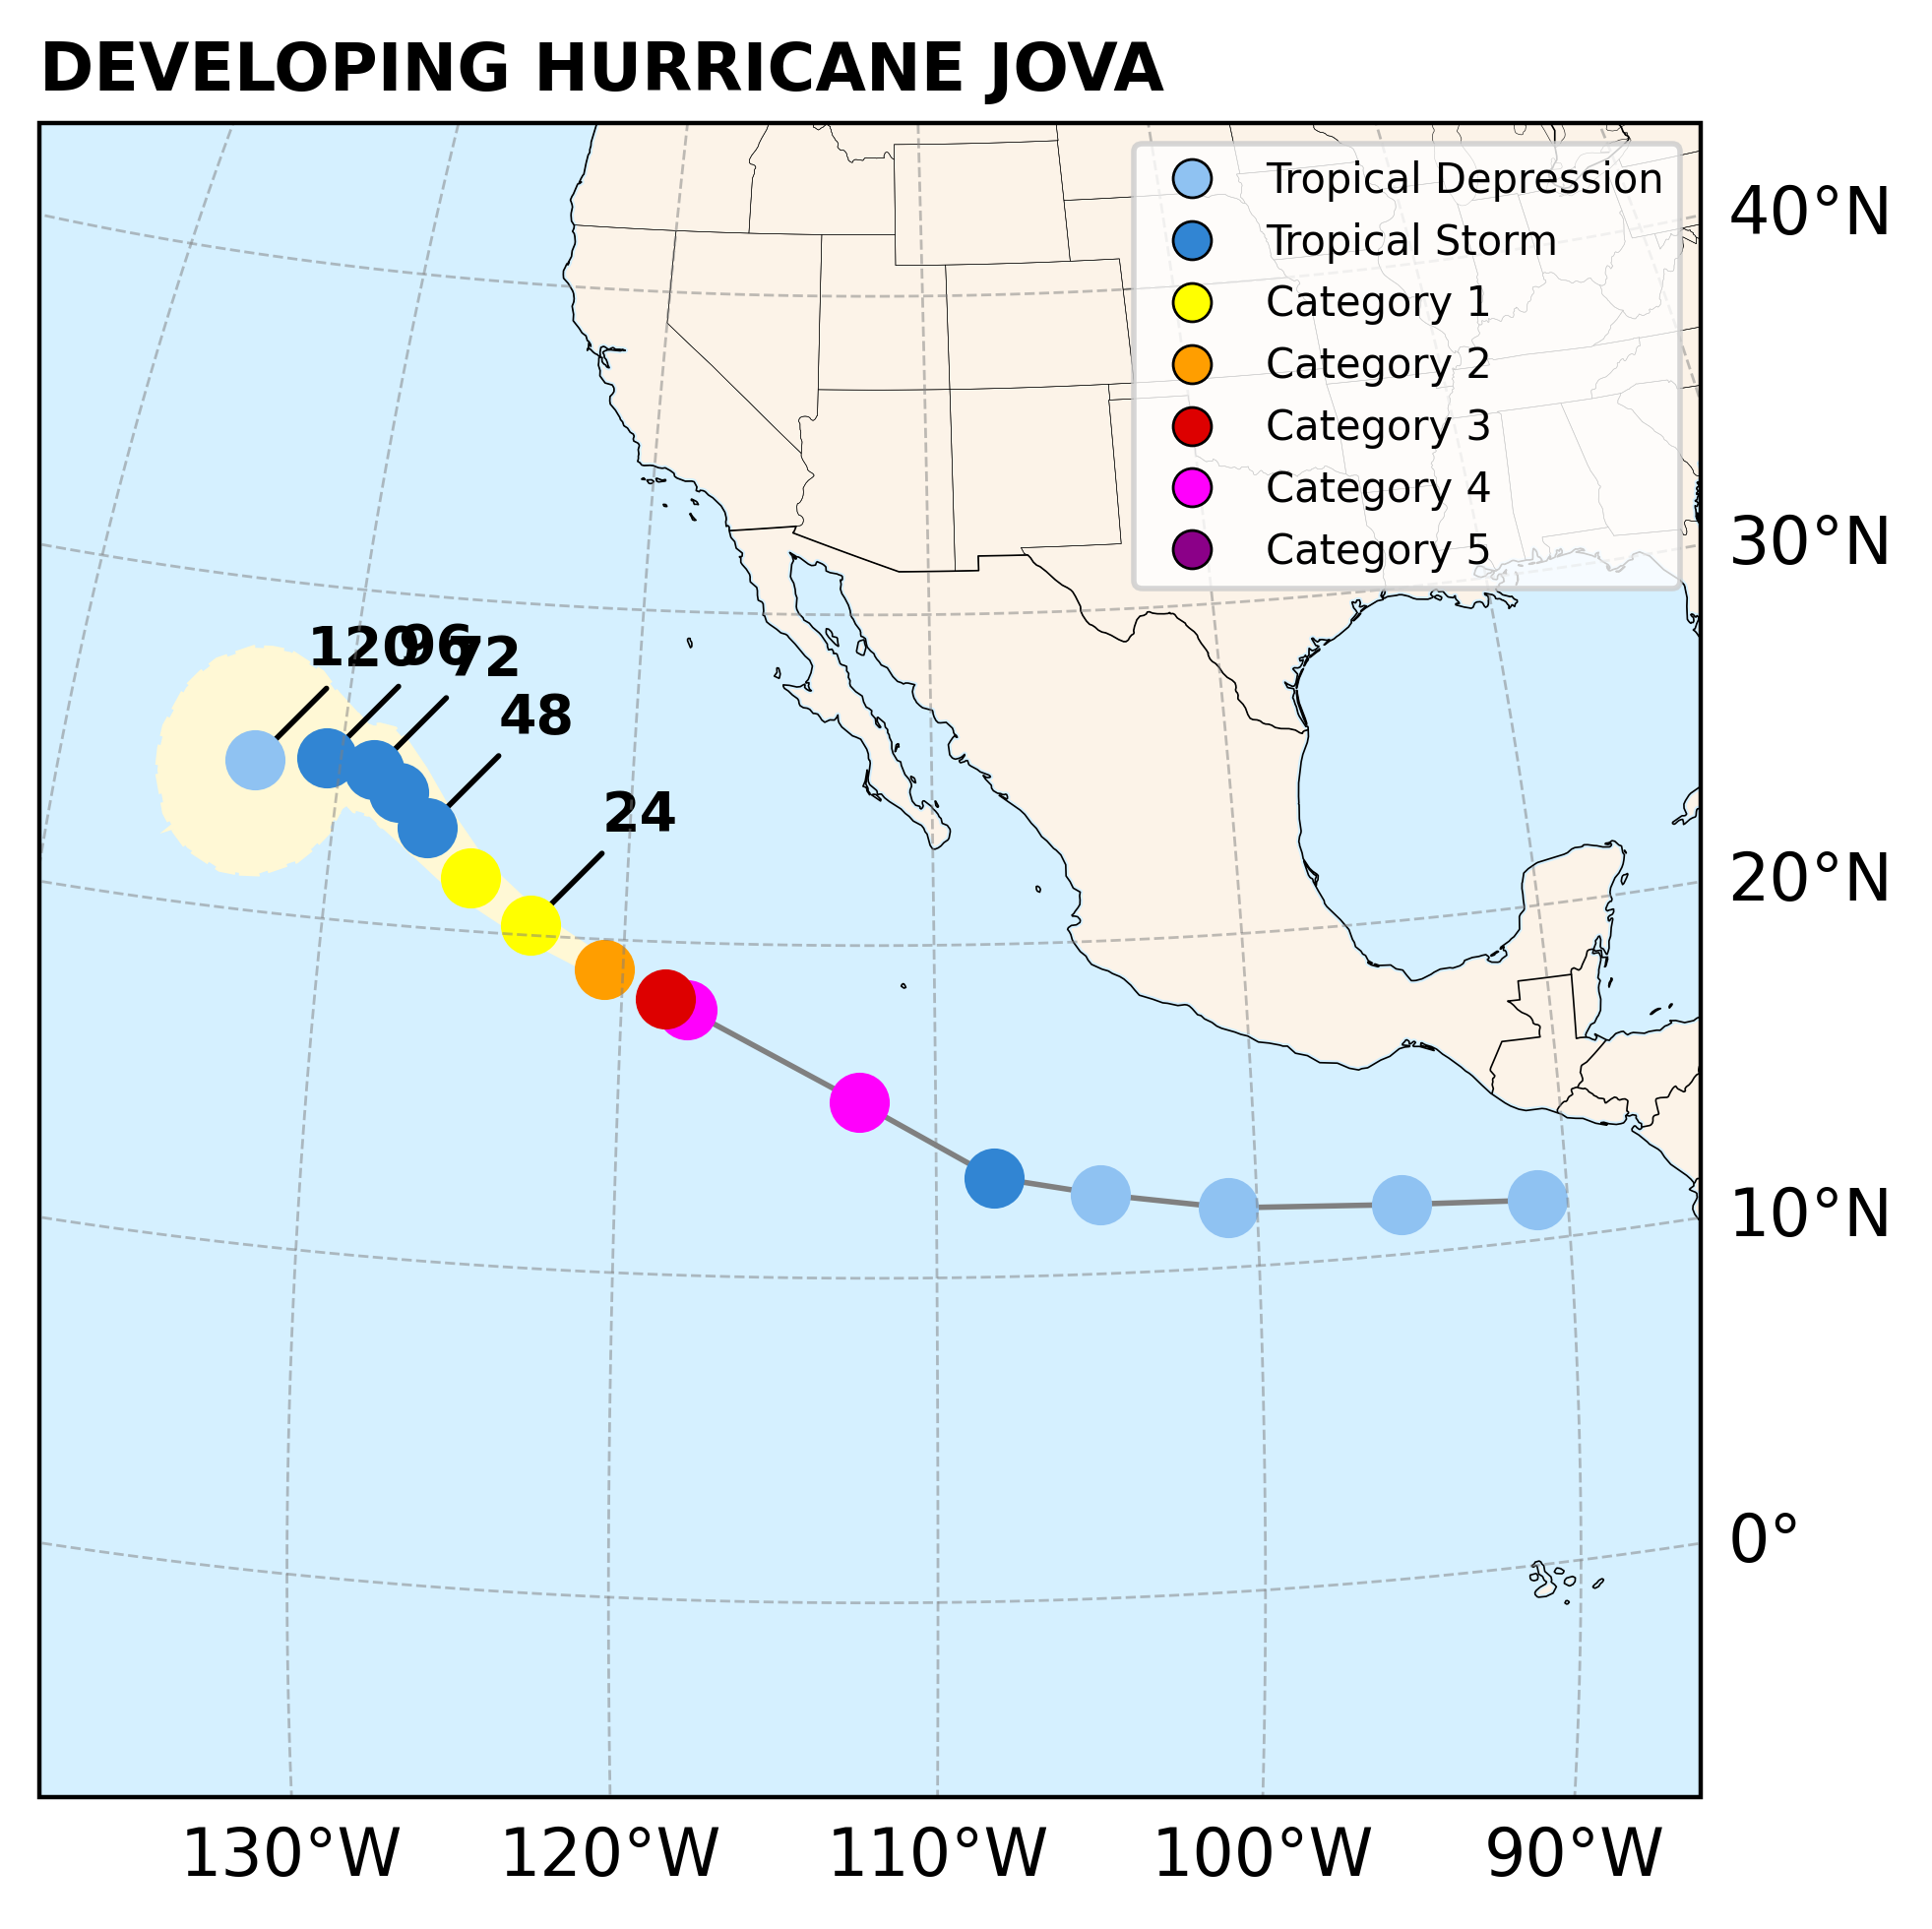

In [50]:
import datetime

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.lines as mlines
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np
from cartopy.mpl.ticker import LatitudeFormatter, LatitudeLocator, LongitudeFormatter
from matplotlib.patches import PathPatch
from matplotlib.path import Path
from tropycal.realtime import RealtimeStorm


def get_colors_sshws(wind_speed: int) -> str:
    r"""
    Retrieve the default colors for the Saffir-Simpson Hurricane Wind Scale (SSHWS).

    Parameters
    ----------
    wind_speed : int or list
        Sustained wind speed in knots.

    Returns
    -------
    str
        Hex string for the corresponding color.
    """

    # # If category string passed, convert to wind
    # if isinstance(wind_speed, str):
    #     wind_speed = category_label_to_wind(wind_speed)

    # Return default SSHWS category color scale
    if wind_speed < 5:
        return "#FFFFFF"
    elif wind_speed < 34:
        return "#8FC2F2"  # '#7DB7ED'
    elif wind_speed < 64:
        return "#3185D3"
    elif wind_speed < 83:
        return "#FFFF00"
    elif wind_speed < 96:
        return "#FF9E00"
    elif wind_speed < 113:
        return "#DD0000"
    elif wind_speed < 137:
        return "#FF00FC"
    else:
        return "#8B0088"


def plot_storm(storm: RealtimeStorm, storm_forecast: dict) -> plt.figure:
    by_hour = 12
    storm["should_plot_step"] = [x.hour / by_hour == 0 for x in storm["time"]]
    storm_forecast["already_forcasted"] = [
        (datetime.timedelta(hours=x) + storm_forecast["init"]) <= storm.time.max()
        for x in storm_forecast["fhr"]
    ]
    lats = storm["lat"].tolist() + storm_forecast["lat"]
    lons = storm["lon"].tolist() + storm_forecast["lon"]

    storm_s = min(lats)
    storm_n = max(lats)
    storm_w = max(lons)
    storm_e = min(lons)
    storm_box = (storm_w, storm_e, storm_s, storm_n)
    storm_width = abs(storm_e-storm_w)
    storm_height = abs(storm_s-storm_n)
    
    central_lon = (storm_w + storm_e) / 2
    central_lat = (storm_n + storm_s) / 2


    
    padding_vertical = storm_height/4
    padding_horizontal = storm_width/4

    # If same then it is a box
    plot_height = max([storm_height+padding_vertical, storm_width+padding_horizontal])
    plot_width  = max([storm_height+padding_vertical, storm_width+padding_horizontal])


    plot_n = central_lat + plot_height/2
    plot_s = central_lat - plot_height/2
    plot_e = central_lon + plot_width/2
    plot_w = central_lon - plot_width/2
    plot_box = (plot_w, plot_e, plot_s, plot_n)

    

    # Create an instance of figure and axes
    #fig = plt.figure(figsize=(9, 6), dpi=400)
    fig = plt.figure(figsize=(5,5), dpi=400)



    ax = plt.axes(
        projection=ccrs.Orthographic(
            central_longitude=central_lon, central_latitude=central_lat
        )
    )

    ax.set_title(
        "DEVELOPING HURRICANE " + storm["name"],
        loc="left",
        #fontsize=25,
        fontweight="bold",
    )
    ax.legend(handles=[td, ts, c1, c2, c3, c4, c5], prop={"size": 7.5})

    # ax.set_title(label=storm['name'], loc='left', fontsize=17, fontweight='bold')

    # Plot coastlines and political boundaries
    ax.add_feature(
        cfeature.STATES.with_scale("50m"),
        linewidths=0.1,
        linestyle="solid",
        edgecolor="k",
    )
    ax.add_feature(
        cfeature.BORDERS.with_scale("50m"),
        linewidths=0.3,
        linestyle="solid",
        edgecolor="k",
    )
    ax.add_feature(
        cfeature.COASTLINE.with_scale("50m"),
        linewidths=0.3,
        linestyle="solid",
        edgecolor="k",
    )

    # Fill in continents in light gray
    ax.add_feature(
        cfeature.LAND.with_scale("50m"), facecolor=land_color, edgecolor="face"
    )
    ax.add_feature(
        cfeature.OCEAN.with_scale("50m"), facecolor=water_color, edgecolor="face"
    )

    # Plot Storm (already happened) Dots
    storm_line_x = []
    storm_line_y = []
    for i in range(0, len(storm["lat"])):
        if not storm["should_plot_step"][i]:
            continue
        ax.plot(
            storm["lon"][i],
            storm["lat"][i],
            transform=ccrs.PlateCarree(),
            linewidth=2,
            marker="o",
            markersize=marker_size,
            color=get_colors_sshws(np.nan_to_num(storm["vmax"][i])),
            zorder=2,
        )
        storm_line_x.append(storm["lon"][i])
        storm_line_y.append(storm["lat"][i])

    # Plot Line
    ax.plot(
        storm_line_x,
        storm_line_y,
        transform=ccrs.PlateCarree(),
        linewidth=1,
        color="gray",
        zorder=1,
    )

    # Plot Storm (forecast) Dots
    for i in range(0, len(storm_forecast["lat"])):
        if storm_forecast["already_forcasted"][i]:
            continue

        ax.plot(
            storm_forecast["lon"][i],
            storm_forecast["lat"][i],
            transform=ccrs.PlateCarree(),
            marker="o",
            color=get_colors_sshws(np.nan_to_num(storm_forecast["vmax"][i])),
            markersize=marker_size,
            zorder=2,
        )

        # Lables for hrs after forecast
        if not storm_forecast['fhr'][i]%24==0:
            continue
            
        ax.annotate(
            text=str(storm_forecast["fhr"][i]),
            xy=(storm_forecast["lon"][i], storm_forecast["lat"][i]),
            xycoords="data",
            xytext=(20, 20),
            textcoords="offset points",
            fontweight="bold",
            ha="center",
            va="center",
            arrowprops=dict(
                arrowstyle="-",
                shrinkA=0,
                shrinkB=0,
                connectionstyle="arc3",
                color="k",
            ),
            transform=ccrs.PlateCarree(),
            clip_on=True,
            zorder=1,
        )


    # Plot Cone of Uncertainty (forecast)
    left_boundary: list = []
    right_boundary: list = []

    def closest_point_on_circle(
        cx: float, cy: float, r_lat: float, r_lon: float, px: float, py: float
    ) -> tuple[float, float]:
        """Find the closest point on a circle to an external point."""
        # Vector from circle's center to the point
        vx = px - cx
        vy = py - cy

        # Distance from circle's center to the point
        dist = np.sqrt(vx**2 + vy**2)

        # Normalize the vector
        vx /= dist
        vy /= dist

        # Scale by the circle's radius
        vx *= r_lat
        vy *= r_lat

        # Translate back to circle's center
        qx = cx + vx
        qy = cy + vy

        return qx, qy

    # Plot Cone of Uncertainty (forecast)
    left_boundary = []
    right_boundary = []

    for i in range(len(storm_forecast["lat"])):
        if storm_forecast["already_forcasted"][i]:
            continue
        fhr = storm_forecast["fhr"][i]
        if fhr in my_cone:
            radius_nautical_miles = my_cone[fhr]  # get the radius for the forecast hour

            radius_lat = radius_nautical_miles / 60
            radius_lon = radius_nautical_miles / (
                60 * np.cos(np.radians(storm_forecast["lat"][i]))
            )

            # Calculate left and right boundary points based on the radius
            qx_left, qy_left = closest_point_on_circle(
                storm_forecast["lon"][i],
                storm_forecast["lat"][i],
                radius_lat,
                radius_lat,
                storm_forecast["lon"][i] - radius_lon,
                storm_forecast["lat"][i] - radius_lat,
            )
            qx_right, qy_right = closest_point_on_circle(
                storm_forecast["lon"][i],
                storm_forecast["lat"][i],
                radius_lat,
                radius_lat,
                storm_forecast["lon"][i] + radius_lon,
                storm_forecast["lat"][i] + radius_lat,
            )

            left_boundary.append((qx_left, qy_left))
            right_boundary.append((qx_right, qy_right))

            # Plot individual ellipse (for visualization)
            e = patches.Ellipse(
                (storm_forecast["lon"][i], storm_forecast["lat"][i]),
                width=2 * radius_nautical_miles / 60,
                height=2 * radius_nautical_miles / 60,
                fc=cone_color,
                alpha=1,
                ec=cone_color,
                linestyle="--",
                transform=ccrs.PlateCarree(),
                zorder=0,
            )
            ax.add_patch(e)

    # Combine the left and right boundaries to form the cone
    cone_boundary = left_boundary + right_boundary[::-1] + [left_boundary[0]]

    codes = [Path.MOVETO] + [Path.LINETO] * (len(cone_boundary) - 2) + [Path.CLOSEPOLY]
    path = Path(cone_boundary, codes)
    patch = PathPatch(
        path,
        facecolor=cone_color,
        edgecolor=cone_color,
        alpha=1,
        zorder=0,
        transform=ccrs.PlateCarree(),
    )
    ax.add_patch(patch)


    label_style = {"size": 12, "color": "black"}

    gl = ax.gridlines(
        crs=ccrs.PlateCarree(),
        draw_labels=True,
        linewidth=0.5,
        color="gray",
        alpha=0.5,
        linestyle="--",
    )
    gl.top_labels = False
    gl.left_labels = False
    gl.ylocator = LatitudeLocator()
    gl.xformatter = LongitudeFormatter()
    gl.yformatter = LatitudeFormatter()
    gl.ylabel_style = label_style
    gl.xlabel_style = label_style

    # Zoom in over Storm
    ax.set_extent(plot_box, crs=ccrs.PlateCarree())

    fig.tight_layout()
    
    ax.set_aspect('auto')

    return fig


cone_color = "#fffde6"
cone_color = "#e6f2ff"
cone_color = "#fff8d5"
water_color = "#d5f0ff"
land_color = "#fcf3e8"
land_scale = "50m"
marker_size = 10


legend_size = 7

ex = mlines.Line2D(
    [],
    [],
    linestyle="None",
    ms=legend_size,
    mec="k",
    mew=0.5,
    label="Non-Tropical",
    marker="^",
    color="w",
)
sb = mlines.Line2D(
    [],
    [],
    linestyle="None",
    ms=legend_size,
    mec="k",
    mew=0.5,
    label="Subtropical",
    marker="s",
    color="w",
)
uk = mlines.Line2D(
    [],
    [],
    linestyle="None",
    ms=legend_size,
    mec="k",
    mew=0.5,
    label="Unknown",
    marker="o",
    color="w",
)
td = mlines.Line2D(
    [],
    [],
    linestyle="None",
    ms=legend_size,
    mec="k",
    mew=0.5,
    label="Tropical Depression",
    marker="o",
    color=get_colors_sshws(33),
)
ts = mlines.Line2D(
    [],
    [],
    linestyle="None",
    ms=legend_size,
    mec="k",
    mew=0.5,
    label="Tropical Storm",
    marker="o",
    color=get_colors_sshws(34),
)
c1 = mlines.Line2D(
    [],
    [],
    linestyle="None",
    ms=legend_size,
    mec="k",
    mew=0.5,
    label="Category 1",
    marker="o",
    color=get_colors_sshws(64),
)
c2 = mlines.Line2D(
    [],
    [],
    linestyle="None",
    ms=legend_size,
    mec="k",
    mew=0.5,
    label="Category 2",
    marker="o",
    color=get_colors_sshws(83),
)
c3 = mlines.Line2D(
    [],
    [],
    linestyle="None",
    ms=legend_size,
    mec="k",
    mew=0.5,
    label="Category 3",
    marker="o",
    color=get_colors_sshws(96),
)
c4 = mlines.Line2D(
    [],
    [],
    linestyle="None",
    ms=legend_size,
    mec="k",
    mew=0.5,
    label="Category 4",
    marker="o",
    color=get_colors_sshws(113),
)
c5 = mlines.Line2D(
    [],
    [],
    linestyle="None",
    ms=legend_size,
    mec="k",
    mew=0.5,
    label="Category 5",
    marker="o",
    color=get_colors_sshws(137),
)

my_cone = {
    0: 0,
    12: 16,
    24: 26,
    36: 39,
    48: 53,
    60: 67,
    72: 81,
    96: 99,
    108: 145,
    120: 205,
}

fig = plot_storm(storm, storm_forecast)
fig.show()


In [43]:
fig.savefig(f"TEST_myimage.jpg")

In [ ]:



# Put a background image on for nice sea rendering.
# ax.stock_img()
from matplotlib.offsetbox import AnchoredText
# Create a feature for States/Admin 1 regions at 1:50m from Natural Earth
def main():
    fig = plt.figure()
    ax1 = fig.add_subplot(2, 2, 1,projection=ccrs.Orthographic(central_latitude=-8, central_longitude=125))
    ax1.set_extent([80, 170, -45, 30], crs=ccrs.PlateCarree())
    #ax = plt.axes(projection=ccrs.Orthographic())
    ax2 = fig.add_subplot(2, 2, 2,projection=ccrs.PlateCarree())
    ax2.set_extent([80, 170, -45, 30], crs=ccrs.PlateCarree())


    # Put a background image on for nice sea rendering.
    ax1.stock_img()
    ax2.stock_img()


    # Create a feature for States/Admin 1 regions at 1:50m from Natural Earth
    states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='50m',
        facecolor='none')

    SOURCE = 'Natural Earth'
    LICENSE = 'public domain'

    ax1.add_feature(cfeature.LAND)
    ax1.add_feature(cfeature.COASTLINE)
    ax1.add_feature(states_provinces, edgecolor='gray')

    # Add a text annotation for the license information to the
    # the bottom right corner.
    text = AnchoredText('\u00A9 {}; license: {}'
                        ''.format(SOURCE, LICENSE),
                        loc=4, prop={'size': 12}, frameon=True)
    #ax1.add_artist(text)

    plt.show()

main()

In [ ]:
import numpy as np
def workaround_gridlines(src_proj, labels=True):
    # Workaround for plotting lines of constant latitude/longitude as gridlines
    # labels not supported for this projection.
    lats = np.linspace(-90, 90, num=181, endpoint=True)
    lons = np.linspace(0, 360, num=360, endpoint=False)

    yn = np.zeros(len(lats))
    lona = lons + yn.reshape(len(lats),1)
    cs2 = plt.contour(lons, lats, lona, 10, transform=src_proj, colors='b', linestyles='dashed')
    plt.clabel(cs2, fontsize=9, inline=True)

    yt = np.zeros(len(lons))
    lata = lats.reshape(len(lats),1) + yt
    cs = plt.contour(lons, lats, lata, 10, transform=src_proj, colors='r', linestyles='dashed')
    plt.clabel(cs, fontsize=9, inline=True)


def main():
    trgt_proj = ccrs.Orthographic(central_latitude=-90)
    src_proj = ccrs.PlateCarree()
    src_crs = ccrs.Geodetic()

    ax = plt.axes(projection=trgt_proj)
    ax.stock_img()

    ln = np.array([-179, 175])
    lt = np.array([-60, -65])

    # Plot gridlines
    workaround_gridlines(src_proj)

    ax.set_extent((ln.min(), ln.max(), lt.min(), lt.max()), crs=src_proj)
    ax.coastlines(resolution='110m', color='black', linewidth=0.5, zorder=1)

    plt.plot(ln, lt, '-k', transform=src_crs)
    plt.scatter(x=ln, y=lt, transform=src_crs)

    plt.show()
main()